In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from dataset_creation import generate_pendulum_dataset, read_pendulum_data

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

def single_dataset_plotting(time, theta, image_name):
    plt.figure(figsize=(10,6))
    plt.plot(time, theta)
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Displacement (radians)')
    plt.title('Simple Pendulum Motion')
    plt.grid(True)
    #plt.text(0.5 * max(time), max(theta), params_str, verticalalignment='top', horizontalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue"))

    plt.tight_layout()
    plt.savefig(image_name)
    plt.show()


def plot_angular_displacement(time, theta, parameters, save_path='./images/last_simulation.png'):
    """
    Function to plot angular displacement of the pendulum over time.
    """
    plt.figure(figsize=(10,6))
    plt.plot(time, theta)
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Displacement (radians)')
    plt.title('Simple Pendulum Motion')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


def plot_actual_vs_predicted(y_test, y_pred, sample_indices, title="Actual vs. Predicted Angular Displacement"):
    """
    Function to plot actual vs. predicted angular displacements for given samples.
    """
    n_samples = len(sample_indices)
    
    fig, axs = plt.subplots(n_samples, figsize=(12, 6 * n_samples))
    
    # If there's only one sample, make axs a list
    if n_samples == 1:
        axs = [axs]
    
    for idx, ax in zip(sample_indices, axs):
        ax.plot(y_test[idx], label="Actual")
        ax.plot(y_pred[idx], label="Predicted")
        ax.set_title(f"{title} - Sample {idx}")
    
    plt.show()


def normalize_data(data):
    """Normalize data to [0, 1] range."""
    min_val = min(data)
    max_val = max(data)
    return [(x - min_val) / (max_val - min_val) for x in data], min_val, max_val

def denormalize_data(normalized_data, min_val, max_val):
    """Denormalize data from [0, 1] range to original range."""
    return [x * (max_val - min_val) + min_val for x in normalized_data]

def normalize_dataset(dataset):
    # Normalize parameters
    params_data = [sample['parameters'] for sample in dataset]
    normalized_params, params_min, params_max = zip(*[normalize_data(params) for params in params_data])

    # Normalize theta_data
    theta_data = [sample['data']['theta_data'] for sample in dataset]
    normalized_theta, theta_min, theta_max = zip(*[normalize_data(theta) for theta in theta_data])

    # Store normalized data back
    for idx, sample in enumerate(dataset):
        sample['parameters'] = normalized_params[idx]
        sample['data']['theta_data'] = normalized_theta[idx]

    # Return normalization info for each dataset for possible denormalization
    normalization_info = {
        'params_min': params_min,
        'params_max': params_max,
        'theta_min': theta_min,
        'theta_max': theta_max
    }

    return dataset, normalization_info


def get_best_model_path(models_dir="models"):
    """
    Get the path of the model with the smallest validation loss.
    
    Assumes model filenames are in the format "weights-{epoch:02d}-{val_loss}.hdf5".
    """

    # List all files in the models directory
    files = os.listdir(models_dir)
    
    # Filter out files that don't match the expected pattern
    valid_files = [f for f in files if f.startswith("weights-") and f.endswith(".hdf5")]
    
    # Extract validation loss from each valid filename and get the filename with the minimum loss
    best_file = min(valid_files, key=lambda x: float(x.split('-')[2].rstrip('.hdf5')))
    print(best_file)

    return os.path.join(models_dir, best_file)

---

### **Genetate Dataset**
##### **Parameters**
- **Initial Angular Displacement (`theta0`)**  
  The starting angle of the pendulum's motion.  
  📌 Range: `-π to π` radians

- **Pendulum Length (`L`)**  
  Distance from the pivot to the pendulum's center of mass.  
  📌 Range: `0.5 to 2.0` meters

- **Time Step (`dt`)**  
  Interval used for simulation updates.  
  📌 Typical Value: `0.1` seconds

- **Simulation Duration (`T`)**  
  Overall time of the simulation.  
  📌 Range: `500 to 1500` seconds

- **Damping Coefficient (`b`)**  
  Quantifies energy dissipation in pendulum motion.  
  📌 Range: `0.001 to 0.1`

- **Cross-Sectional Area (`A`)**  
  Affects the drag the pendulum experiences.  
  📌 Range: `0.005 to 0.02 m^2`

- **Drag Coefficient (`Cd`)**  
  Describes pendulum's aerodynamic characteristics.  
  📌 Range: `0.2 to 0.5`

- **Driving Force Amplitude (`F0`)**  
  Amplitude of the external force applied to the pendulum. This can be used to model the effects of external perturbations or to sustain the motion against damping.  
  📌 Range: `0.0 to 0.5`

- **Driving Force Frequency (`omega_drive`)**  
  Frequency of the external force. This determines how often the external force oscillates, potentially leading to resonance phenomena in the pendulum.  
  📌 Range: `0.0 to 2π` radians/second

---

In [15]:
# Generate dataset
n_samples = 300
time_s = 200
dataset = generate_pendulum_dataset(n_samples, time_s)

Data sample 0 saved to dataset\pendulum_data_0.csv
Data sample 1 saved to dataset\pendulum_data_1.csv
Data sample 2 saved to dataset\pendulum_data_2.csv
Data sample 3 saved to dataset\pendulum_data_3.csv
Data sample 4 saved to dataset\pendulum_data_4.csv
Data sample 5 saved to dataset\pendulum_data_5.csv
Data sample 6 saved to dataset\pendulum_data_6.csv
Data sample 7 saved to dataset\pendulum_data_7.csv
Data sample 8 saved to dataset\pendulum_data_8.csv
Data sample 9 saved to dataset\pendulum_data_9.csv
Data sample 10 saved to dataset\pendulum_data_10.csv
Data sample 11 saved to dataset\pendulum_data_11.csv
Data sample 12 saved to dataset\pendulum_data_12.csv
Data sample 13 saved to dataset\pendulum_data_13.csv
Data sample 14 saved to dataset\pendulum_data_14.csv
Data sample 15 saved to dataset\pendulum_data_15.csv
Data sample 16 saved to dataset\pendulum_data_16.csv
Data sample 17 saved to dataset\pendulum_data_17.csv
Data sample 18 saved to dataset\pendulum_data_18.csv
Data sample 1

Data sample 155 saved to dataset\pendulum_data_155.csv
Data sample 156 saved to dataset\pendulum_data_156.csv
Data sample 157 saved to dataset\pendulum_data_157.csv
Data sample 158 saved to dataset\pendulum_data_158.csv
Data sample 159 saved to dataset\pendulum_data_159.csv
Data sample 160 saved to dataset\pendulum_data_160.csv
Data sample 161 saved to dataset\pendulum_data_161.csv
Data sample 162 saved to dataset\pendulum_data_162.csv
Data sample 163 saved to dataset\pendulum_data_163.csv
Data sample 164 saved to dataset\pendulum_data_164.csv
Data sample 165 saved to dataset\pendulum_data_165.csv
Data sample 166 saved to dataset\pendulum_data_166.csv
Data sample 167 saved to dataset\pendulum_data_167.csv
Data sample 168 saved to dataset\pendulum_data_168.csv
Data sample 169 saved to dataset\pendulum_data_169.csv
Data sample 170 saved to dataset\pendulum_data_170.csv
Data sample 171 saved to dataset\pendulum_data_171.csv
Data sample 172 saved to dataset\pendulum_data_172.csv
Data sampl

Dataset 1 read from dataset\pendulum_data_0.csv
Dataset 2 read from dataset\pendulum_data_1.csv
Dataset 3 read from dataset\pendulum_data_10.csv
Dataset 4 read from dataset\pendulum_data_11.csv
Dataset 5 read from dataset\pendulum_data_12.csv
Dataset 6 read from dataset\pendulum_data_13.csv
Dataset 7 read from dataset\pendulum_data_14.csv
Dataset 8 read from dataset\pendulum_data_15.csv
Dataset 9 read from dataset\pendulum_data_16.csv
Dataset 10 read from dataset\pendulum_data_17.csv
Dataset 11 read from dataset\pendulum_data_18.csv
Dataset 12 read from dataset\pendulum_data_19.csv
Dataset 13 read from dataset\pendulum_data_2.csv
Dataset 14 read from dataset\pendulum_data_20.csv
Dataset 15 read from dataset\pendulum_data_21.csv
Dataset 16 read from dataset\pendulum_data_22.csv
Dataset 17 read from dataset\pendulum_data_23.csv
Dataset 18 read from dataset\pendulum_data_24.csv
Dataset 19 read from dataset\pendulum_data_25.csv
Dataset 20 read from dataset\pendulum_data_26.csv
Dataset 21 r

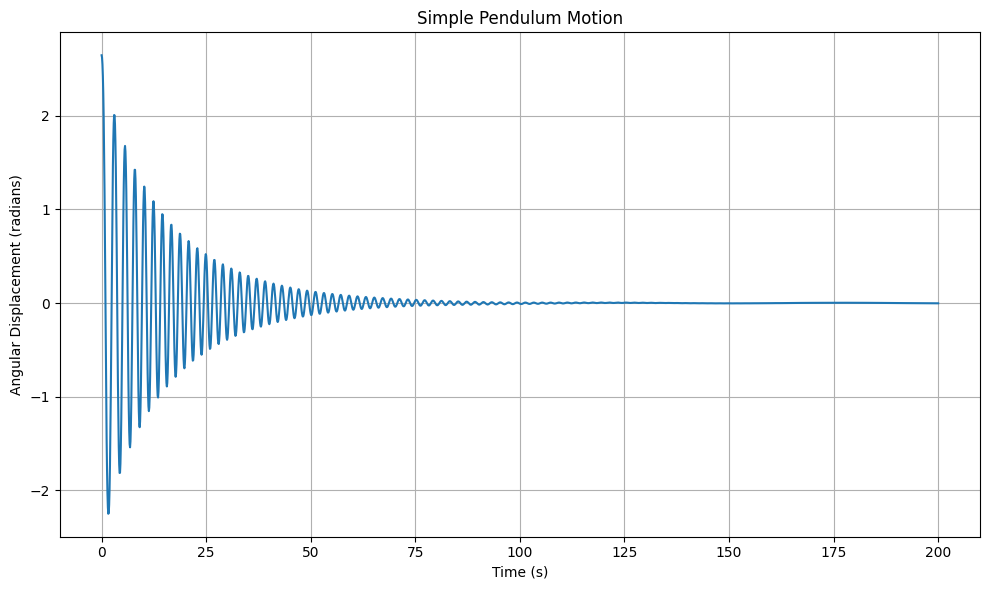

In [3]:
dataset = read_pendulum_data(30)
time = dataset[-1]['data']['time_data']
theta = dataset[-1]['data']['theta_data']
#params = dataset[-1]['parameters']
#params_str = "\n".join([f"{key}: {value:.3f}" for key, value in params.items()])

single_dataset_plotting(time, theta, './images/last_simulation.png')

#### Data Preparation

In [1]:
normalized_dataset, _ = normalize_dataset(dataset)  # Use your normalization function
time = normalized_dataset[-1]['data']['time_data']
theta = normalized_dataset[-1]['data']['theta_data']
single_dataset_plotting(time, theta, './images/last_simulation_normalized')

NameError: name 'normalize_dataset' is not defined

In [17]:
n_initial = 100 #10 seconds
params_data = [item['parameters'] for item in dataset] #normalized_dataset
theta_data = [item['data']['theta_data'][:n_initial] for item in dataset] #normalized_dataset

X = [params + theta for params, theta in zip(params_data, theta_data)]
y = [item['data']['theta_data'][n_initial:] for item in dataset] #normalized_dataset

len_X = len(X[0])
len_y = len(y[0])
print(f'Normalized parameters (X): {len(X[0])}')  # Print the first sample
print(f'Normalized theta data (y): {len(y[0])}')  # Print the first sample

Normalized parameters (X): 106
Normalized theta data (y): 1901


In [18]:
# Splitting data into training, validation, and testing
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Reshape X_train, X_val, X_test for LSTM
X_train = np.array(X_train).reshape((len(X_train), len(X_train[0]), 1))
X_val = np.array(X_val).reshape((len(X_val), len(X_val[0]), 1))
X_test = np.array(X_test).reshape((len(X_test), len(X_test[0]), 1))

y_train = pad_sequences(y_train, dtype='float32', padding='post')
y_val = pad_sequences(y_val, dtype='float32', padding='post')
y_test = pad_sequences(y_test, dtype='float32', padding='post')

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [19]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(len(X[0]), 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(len(y[0])))

model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse'])

model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse'])

In [20]:
# Step 3: Train and Save Models
checkpoint = ModelCheckpoint(os.path.join('models', "best_model.hdf5"), 
                             save_best_only=True, 
                             monitor='val_loss', 
                                 mode='min')

model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=2000, batch_size=1, 
          callbacks=[checkpoint])

Epoch 1/2000
210/210 [==============================] - 19s 62ms/step - loss: 0.0737 - mse: 0.0737 - val_loss: 0.0403 - val_mse: 0.0403
Epoch 2/2000
210/210 [==============================] - 12s 56ms/step - loss: 0.0658 - mse: 0.0658 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 3/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0621 - mse: 0.0621 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 4/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0601 - mse: 0.0601 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 5/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0578 - mse: 0.0578 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 6/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0564 - mse: 0.0564 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 7/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 8/2000
210/210 [==========================

Epoch 61/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0457 - mse: 0.0457 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 62/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0421 - mse: 0.0421 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 63/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0416 - mse: 0.0416 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 64/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0407 - mse: 0.0407 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 65/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0405 - mse: 0.0405 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 66/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0413 - mse: 0.0413 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 67/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0427 - mse: 0.0427 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 68/2000
210/210 [==================

210/210 [==============================] - 14s 69ms/step - loss: 0.0397 - mse: 0.0397 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 121/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 122/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 123/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 124/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 125/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 126/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 127/2000
210/210 [=========================

210/210 [==============================] - 14s 69ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 180/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 181/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 182/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 183/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 184/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 185/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 186/2000
210/210 [=========================

210/210 [==============================] - 15s 69ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 239/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 240/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0418 - val_mse: 0.0418
Epoch 241/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 242/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0372 - val_mse: 0.0372
Epoch 243/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0370 - val_mse: 0.0370
Epoch 244/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 245/2000
210/210 [=========================

210/210 [==============================] - 14s 69ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 298/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 299/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 300/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0273 - val_mse: 0.0273
Epoch 301/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 302/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 303/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 304/2000
210/210 [=========================

210/210 [==============================] - 15s 69ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 357/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 358/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 359/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0200 - mse: 0.0200 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 360/2000
210/210 [==============================] - 15s 72ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 361/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 362/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 363/2000
210/210 [=========================

210/210 [==============================] - 15s 69ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 416/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0272 - val_mse: 0.0272
Epoch 417/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 418/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0276 - val_mse: 0.0276
Epoch 419/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 420/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 421/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 422/2000
210/210 [=========================

210/210 [==============================] - 33s 157ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 475/2000
210/210 [==============================] - 33s 156ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 476/2000
210/210 [==============================] - 33s 156ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 477/2000
210/210 [==============================] - 33s 156ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 478/2000
210/210 [==============================] - 33s 156ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 479/2000
210/210 [==============================] - 33s 155ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 480/2000
210/210 [==============================] - 33s 156ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0305 - val_mse: 0.0305
Epoch 481/2000
210/210 [==================

210/210 [==============================] - 33s 159ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 534/2000
210/210 [==============================] - 24s 113ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 535/2000
210/210 [==============================] - 12s 55ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 536/2000
210/210 [==============================] - 13s 62ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 537/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 538/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 539/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 540/2000
210/210 [=======================

210/210 [==============================] - 14s 68ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 593/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 594/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 595/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 596/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 597/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 598/2000
210/210 [==============================] - 15s 71ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0719 - val_mse: 0.0719
Epoch 599/2000
210/210 [=========================

210/210 [==============================] - 15s 70ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 652/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 653/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 654/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 655/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 656/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 657/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 658/2000
210/210 [=========================

210/210 [==============================] - 34s 164ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 711/2000
210/210 [==============================] - 34s 164ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0295 - val_mse: 0.0295
Epoch 712/2000
210/210 [==============================] - 35s 165ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 713/2000
210/210 [==============================] - 35s 165ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 714/2000
210/210 [==============================] - 34s 163ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 715/2000
210/210 [==============================] - 34s 164ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 716/2000
210/210 [==============================] - 34s 164ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 717/2000
210/210 [==================

210/210 [==============================] - 14s 65ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 770/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 771/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 772/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 773/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 774/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 775/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 776/2000
210/210 [=========================

210/210 [==============================] - 15s 69ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 829/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 830/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 831/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0287 - val_mse: 0.0287
Epoch 832/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 833/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 834/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 835/2000
210/210 [=========================

210/210 [==============================] - 15s 69ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 888/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 889/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 890/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 891/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 892/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 893/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 894/2000
210/210 [=========================

210/210 [==============================] - 15s 70ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 947/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0287 - val_mse: 0.0287
Epoch 948/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 949/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 950/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0365 - val_mse: 0.0365
Epoch 951/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 952/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 953/2000
210/210 [=========================

210/210 [==============================] - 15s 69ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0272 - val_mse: 0.0272
Epoch 1006/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 1007/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 1008/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 1009/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 1010/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 1011/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 1012/2000
210/210 [==================

210/210 [==============================] - 15s 70ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 1065/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 1066/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0375 - val_mse: 0.0375
Epoch 1067/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0295 - val_mse: 0.0295
Epoch 1068/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 1069/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 1070/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 1071/2000
210/210 [==================

210/210 [==============================] - 15s 69ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 1124/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 1125/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 1126/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0272 - val_mse: 0.0272
Epoch 1127/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 1128/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 1129/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 1130/2000
210/210 [==================

210/210 [==============================] - 15s 69ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 1183/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 1184/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 1185/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0186 - mse: 0.0186 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 1186/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 1187/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 1188/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 1189/2000
210/210 [==================

210/210 [==============================] - 15s 69ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 1242/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 1243/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 1244/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 1245/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 1246/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 1247/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 1248/2000
210/210 [==================

210/210 [==============================] - 14s 69ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 1301/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 1302/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0272 - val_mse: 0.0272
Epoch 1303/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 1304/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 1305/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0258 - val_mse: 0.0258
Epoch 1306/2000
210/210 [==============================] - 15s 70ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 1307/2000
210/210 [==================

210/210 [==============================] - 15s 69ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 1360/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 1361/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 1362/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 1363/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 1364/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 1365/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 1366/2000
210/210 [==================

210/210 [==============================] - 15s 69ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 1419/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 1420/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 1421/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 1422/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 1423/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 1424/2000
210/210 [==============================] - 15s 69ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 1425/2000
210/210 [==================

210/210 [==============================] - 14s 68ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 1478/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 1479/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 1480/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 1481/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 1482/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 1483/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 1484/2000
210/210 [==================

210/210 [==============================] - 14s 68ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 1537/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 1538/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 1539/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0276 - val_mse: 0.0276
Epoch 1540/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 1541/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 1542/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 1543/2000
210/210 [==================

210/210 [==============================] - 14s 69ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 1596/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 1597/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 1598/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 1599/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 1600/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 1601/2000
210/210 [==============================] - 14s 67ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 1602/2000
210/210 [==================

210/210 [==============================] - 14s 68ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 1655/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 1656/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 1657/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 1658/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0272 - val_mse: 0.0272
Epoch 1659/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 1660/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 1661/2000
210/210 [==================

210/210 [==============================] - 14s 68ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 1714/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 1715/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0287 - val_mse: 0.0287
Epoch 1716/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 1717/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 1718/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 1719/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 1720/2000
210/210 [==================

210/210 [==============================] - 14s 68ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 1773/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 1774/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 1775/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 1776/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 1777/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 1778/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0250 - val_mse: 0.0250
Epoch 1779/2000
210/210 [==================

210/210 [==============================] - 14s 67ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0273 - val_mse: 0.0273
Epoch 1832/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 1833/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 1834/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 1835/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 1836/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 1837/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 1838/2000
210/210 [==================

210/210 [==============================] - 14s 68ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0295 - val_mse: 0.0295
Epoch 1891/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 1892/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 1893/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 1894/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0295 - val_mse: 0.0295
Epoch 1895/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 1896/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 1897/2000
210/210 [==================

210/210 [==============================] - 14s 68ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 1950/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 1951/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0276 - val_mse: 0.0276
Epoch 1952/2000
210/210 [==============================] - 14s 69ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 1953/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0273 - val_mse: 0.0273
Epoch 1954/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 1955/2000
210/210 [==============================] - 14s 68ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 1956/2000
210/210 [==================

In [21]:
# Step 4: Evaluate and Plot Results
best_model_path = './models/best_model.hdf5' # best_model_path = get_best_model_path()
best_model = load_model(best_model_path)

# Predict
y_pred = best_model.predict(X_test)

# Reshaping y_pred and y_test for the comparison plots
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])

2/2 [==============================] - 1s 20ms/step


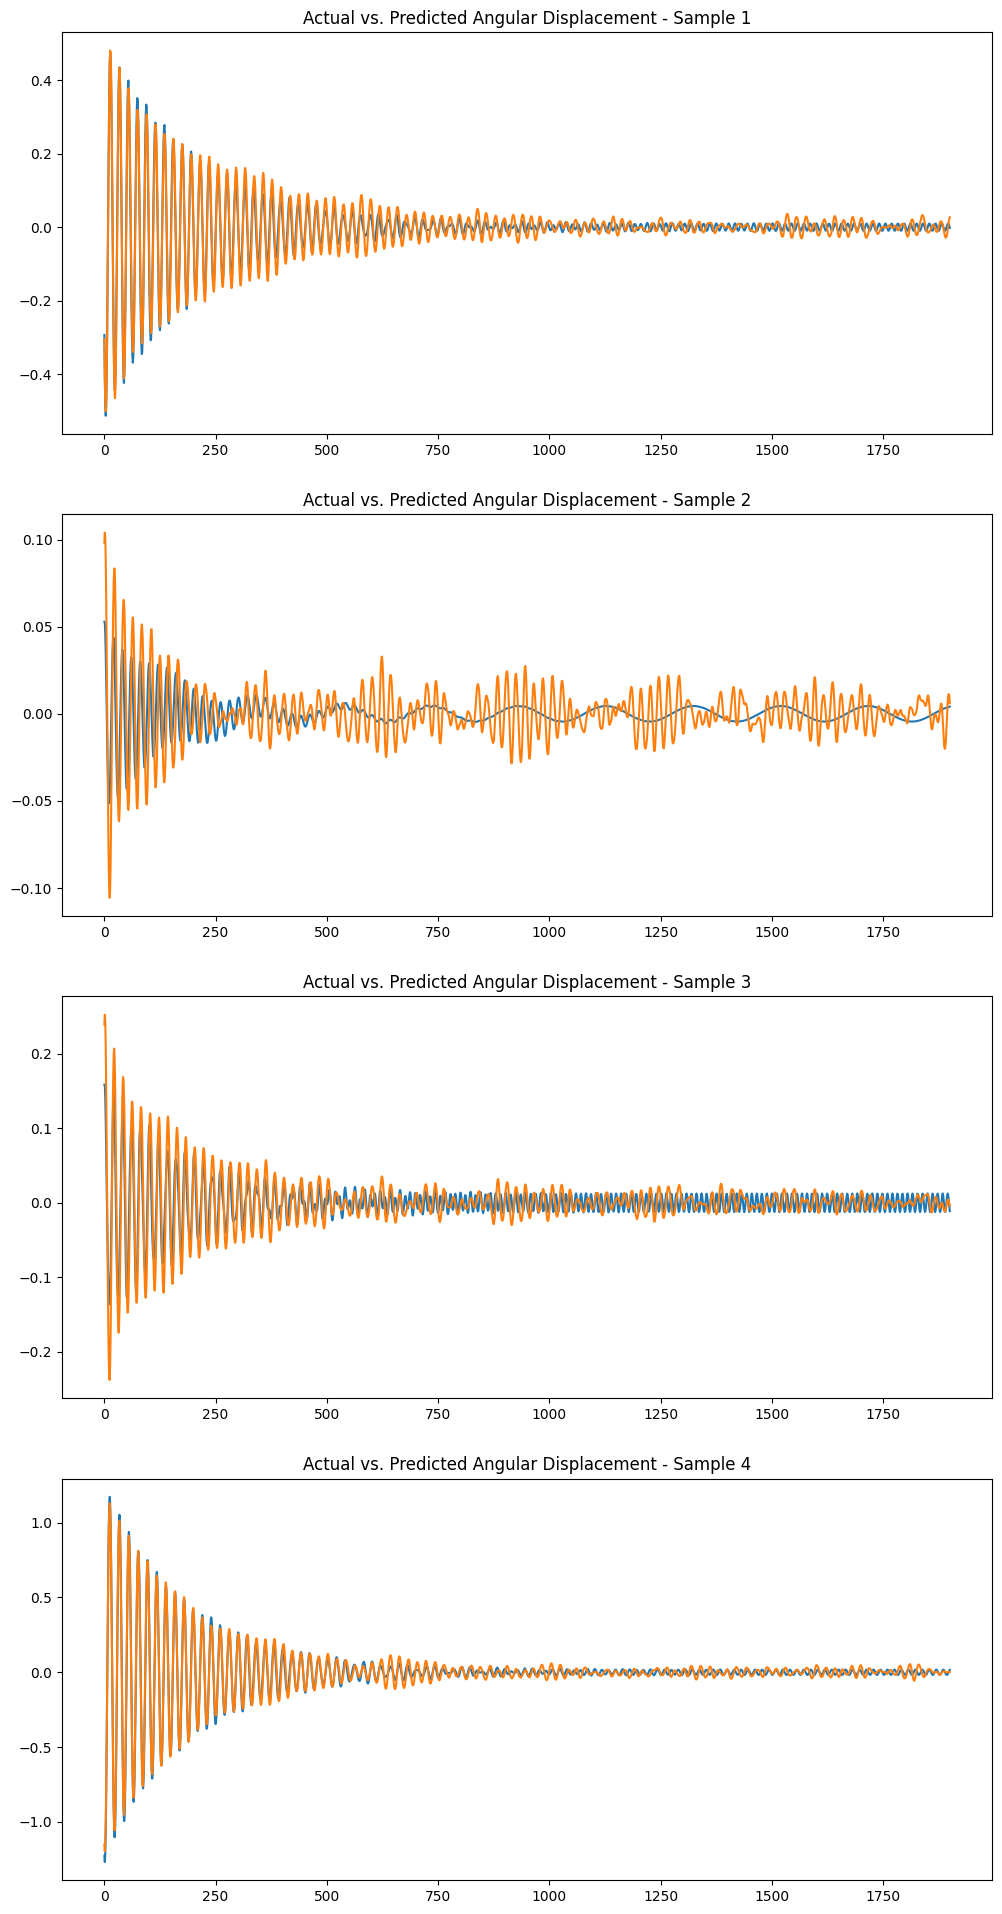

In [22]:
sample_indices = [1, 2, 3, 4]  # choose any indices you want
#y_pred = np.squeeze(y_pred)
plot_actual_vs_predicted(y_test, y_pred, sample_indices)

In [11]:
print(f'Shape of y_test: {np.array(y_test).shape}')
print(f'Shape of y_pred: {np.array(y_pred).shape}')

Shape of y_test: (5, 1901)
Shape of y_pred: (5, 1901)
